In [1]:
%load_ext autoreload
%autoreload 2

# Basic Examples

The `dukes100nm_glycerol` folder contains three time series of 100nm (diameter) SiO2 nanoparticles dispersed in a glycerol-water mixture. 

This tutorial shows how to:
1. Load data and define the setup.
2. Process the datasets and calculate:
    * The azimuthally integrated SAXS curves
    * XPCS intensity auto-correlation functions
    * XSVS photon statistics
3. Display and fit the correlation functions.
4. Working with the database:
    * Display entries
    * Select measurements
    * Discard measurements
5. Determine the viscosity of the solution.

**Importing Xana and Setting up the Figure Style**

In [2]:
from Xana import Xana

import numpy as np
import seaborn as sns

sns.set_style('ticks', rc={'figure.dpi':300})
sns.set_context('notebook')

# import pandas as pd
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
# pd.set_option('display.max_colwidth', None)

# Loading Data and Defineing the Setup

For each type of analysis a *setupfile* is required that contains information about the geometry (sample-detector distance, wavelength, etc.) but also about the ROIs where the XPCS and XSVS analysis will be performed.

In [3]:
d = Xana(fmtstr='id10_eiger_single_edf', # format string that defines how the date are read
         sample='100nm-SiO2', # optional: sample name used in data base
         maskfile='./Xana_example/mask_array.npy', # optional: file that conatains the blemish / mask
         detector='eiger500k') # specify the detector

By connecting the Xana instance to a directory that folder is searched for datasets and corresponding metadata information. The information are received based on the `fmtstr` keyword. Here, we use "id10_eiger_single_edf" as the example data were measured at ID10 at the ESRF. See the [Xana Documentation](https://xana.readthedocs.io/en/latest/) for further details. The metadata are stored in the `meta` attribute. 


In [6]:
d.connect('./dukes100nm_glycerol/xpcs/exp320us_att0/')
d.meta

,series,t_exposure,t_readout,t_latency,nframes,first,last,master,datdir
0,1,0.00032,0.00001,0.0,1500,0,1499,img_eiger_0001_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...
1,2,0.00032,0.00001,0.0,1500,0,1499,img_eiger_0002_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...
2,3,0.00032,0.00001,0.0,1500,0,1499,img_eiger_0003_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...


The columns are

| Column        | Description   |
| ------------- |---------------|
| col 3 is      | right-aligned |
| col 2 is      | centered      |
| zebra stripes | are neat      |

Now the data can be loaded using the `get_series`-method. **All** Xana methods that process data take the index of the metadata table as first argument. 

The data can be loaded into a 3D-array setting the `method` keyword to 'full' (default). The dimensions are (time x Pixel-X x Pixel-Y). For demonstration purposes, we read only the first 100 images by setting the `last` keyword to 100. The first image (with index 0) is skipped by setting the `first` keyword to 1. In general, the `first` and `last` keywords can be used to analyse subsets of a time series.

In [9]:
data = d.get_series(0, method='full', verbose=True, first=1, last=100)
print('The returned array has the dimensions: ', data.shape)

First images is:  1
Last image is:  100
Loading data in chunks of 256 images.
[============================================================] 100.0%..
The returned array has the dimensions:  (100, 514, 1030)


To define the ROIs for the XPCS/XSVS analysis, the data are averaged over the time axis. The command is the same except the `method`-keyword has been changed to 'average'. Now the command will return a list containing the average intensities, `I`, and the variance, `V`.

In [16]:
I, V = d.get_series(0, method='average', verbose=False, first=1)

[============================================================] 100.0%...


Now the setup can be defined. If no dict is passed to the `make_setup` method, the user is prompted to input the parameters. The vector `qv_init` contains a list of tuples. Each tuple should have the q position (or an array of q positions) as first element and the q width as second argument.

The `defineqrois` method requires an image, I, and the `qv_init` list as input parameters. Using the `phiv_init` keyword, angular slices (in degrees) can be selected.

Added the following Q-values [nm-1]:
[0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.06  0.065 0.07  0.075 0.125]


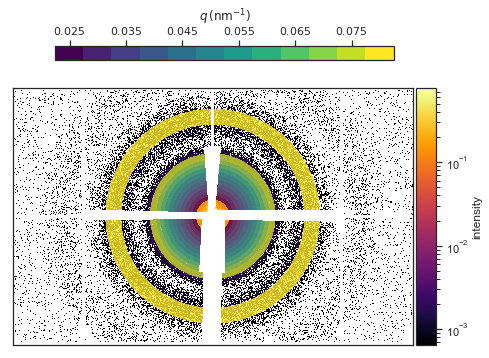

In [21]:
d.setup.make(**{'center': [516, 257], # position of the direct beam in pixels
                'wavelength': 1.5, # X-ray wavelength in Angstrom
                'distance': 5 # sample-detector distance in m
               }
            )

# q-vector and width in nm-1
qv_init = [(np.arange(0.025, 0.08, .005), .008),
           (.125, .02)]

# anglular slices in degress (10, 150) with a width of 30 degrees
phiv_init = [([10, 150], 30)]

d.defineqrois(I, qv_init=qv_init, plot='ROIS', d=400)#, mirror=True, phiv_init=phiv_init,)

The setup can be saved to load it from different notebooks or scripts. The `maksavdir` method can be used to create directories for saving setupfiles or other results. It creates a new subfolder `setupfiles` (first argument) in the folder specified by the second argument, here in the present folder `./`. Prefix and suffix are added automatically. If a file with the same name already exists, the user is asked if he or she wants to override it.

In [23]:
d.mksavdir('setupfiles', './')
d.savesetup('100nm')

Changing savdir to:
	/Users/reiserm/Xana/docs/source/setupfiles/
Try loading database:
	/Users/reiserm/Xana/docs/source/setupfiles/Analysis_db.pkl
	...loading database failed.
File exists. Save anyway? (No/Yes)	yes

Results saved to:
	/Users/reiserm/Xana/docs/source/setupfiles/setup_100nm.pkl


# Processing Data

We follow the same steps as before to initialize a Xana instance; however, now we load the previously defined and saved setupfile. 

In [3]:
d = Xana(fmtstr='id10_eiger_single_edf', # format string that defines how data are read
         sample='100nm-SiO2', # optional: sample name used in data base
         setupfile='./setupfiles/setup_100nm.pkl',) # we load the previously defined setup

Loaded setupfile:
	/Users/reiserm/Xana/docs/source/setupfiles/setup_100nm.pkl.


The setupfile can also be loaded separately:

In [4]:
d.loadsetup('./setupfiles/setup_100nm.pkl')

Loaded setupfile:
	/Users/reiserm/Xana/docs/source/setupfiles/setup_100nm.pkl.


Again we connect Xana to the directory containing the data:

In [5]:
d.connect('./dukes100nm_glycerol/xpcs/exp320us_att0/')
d.meta

,series,t_exposure,t_readout,t_latency,nframes,first,last,master,datdir
0,1,0.00032,0.00001,0.0,1500,0,1499,img_eiger_0001_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...
1,2,0.00032,0.00001,0.0,1500,0,1499,img_eiger_0002_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...
2,3,0.00032,0.00001,0.0,1500,0,1499,img_eiger_0003_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...


As each run of the analysis routines creates a separate file, we want to create a new directory for the results. Again we can use the `mksavdir` command.

In [6]:
d.mksavdir('100nm_glycerol', './')

Changing savdir to:
	/Users/reiserm/Xana/docs/source/100nm_glycerol/
Try loading database:
	/Users/reiserm/Xana/docs/source/100nm_glycerol/Analysis_db.pkl
Successfully loaded database


The results of the analysis are stored (pickled) as dictionaries containing all necessary information on the analysis. Additionally, an entry is added in the analysis **database**. The default file is `Analysis_db.pkl`. If that file does not exist, the database has to be initialized **after** connecting with a dataset. That is because the columns of the database are taken from the metadata table.

In [31]:
d.init_db()


Results saved to:
	/Users/reiserm/Xana/docs/source/100nm_glycerol/Analysis_db.pkl


Different types of analysis can be performed as shown in the next cell using the `analyze` method.
* As for loading the data, the first argument is the index of the metadata table and defines the series you want to analyze. -1 means that every series of the metadata tabel is analyzed.
* The second argument defines the type of analysis:
    * **xpcs** uses pyxpcs to calcualte intensity auto-correlation functions
    * **xpcs_evt** uses the eventcorrelator to calculate correlation functions
    * **saxs** computes the azimuthally integrated intensity
    * **xsvs** calculates the photon probabilities
* Other kwargs are specific for a specific type of analysis. Again the reader is refferred to the [Xana Documentation](https://xana.readthedocs.io/en/latest/) for further information.

**SAXS Azimuthal Intensity**

In [ ]:
d.analyze(-1, 'saxs', verbose=True, first=1, last=500)

**XPCS Correlation Functions**

In [ ]:
d.analyze(-1, 'xpcs', verbose=True, first=1, twotime_par=1)

**XPCS Eventcorrelator**

In [ ]:
d.analyze(-1, 'xpcs_evt', verbose=True, first=1,)

**XSVS Photon Probabilities**

In [ ]:
d.analyze(-1, 'xsvs', verbose=True, first=1, nbins=64, nprocs=4)

## The Database

In [7]:
!ls ./100nm_glycerol/

Analysis_db.pkl                    xpcs_exp320us_att0_s1_0000.pkl
saxs_exp320us_att0_s1_0000.pkl     xpcs_exp320us_att0_s2_0000.pkl
saxs_exp320us_att0_s2_0000.pkl     xpcs_exp320us_att0_s3_0000.pkl
saxs_exp320us_att0_s3_0000.pkl     xsvs_exp320us_att0_s1_0000.pkl
xpcs_evt_exp320us_att0_s1_0000.pkl xsvs_exp320us_att0_s2_0000.pkl
xpcs_evt_exp320us_att0_s2_0000.pkl xsvs_exp320us_att0_s3_0000.pkl
xpcs_evt_exp320us_att0_s3_0000.pkl


In [7]:
d.db

,use,sample,analysis,series,t_exposure,t_readout,t_latency,nframes,first,last,master,datdir,mod,savname,savfile,setupfile,comment
0,True,100nm-SiO2,saxs,1,0.00032,0.00001,0.0,499,1,499,img_eiger_0001_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...,2020-04-27 13:06:52.557415,saxs_exp320us_att0_s1_0000.pkl,/Users/reiserm/Xana/docs/source/100nm_glycerol...,/Users/reiserm/Xana/docs/source/setupfiles/set...,
1,True,100nm-SiO2,saxs,2,0.00032,0.00001,0.0,499,1,499,img_eiger_0002_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...,2020-04-27 13:06:57.998514,saxs_exp320us_att0_s2_0000.pkl,/Users/reiserm/Xana/docs/source/100nm_glycerol...,/Users/reiserm/Xana/docs/source/setupfiles/set...,
2,True,100nm-SiO2,saxs,3,0.00032,0.00001,0.0,499,1,499,img_eiger_0003_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...,2020-04-27 13:07:04.110523,saxs_exp320us_att0_s3_0000.pkl,/Users/reiserm/Xana/docs/source/100nm_glycerol...,/Users/reiserm/Xana/docs/source/setupfiles/set...,
3,True,100nm-SiO2,xpcs,1,0.00032,0.00001,0.0,1499,1,1499,img_eiger_0001_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...,2020-04-27 13:44:48.661421,xpcs_exp320us_att0_s1_0000.pkl,/Users/reiserm/Xana/docs/source/100nm_glycerol...,/Users/reiserm/Xana/docs/source/setupfiles/set...,
4,True,100nm-SiO2,xpcs,2,0.00032,0.00001,0.0,1499,1,1499,img_eiger_0002_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...,2020-04-27 13:49:05.673616,xpcs_exp320us_att0_s2_0000.pkl,/Users/reiserm/Xana/docs/source/100nm_glycerol...,/Users/reiserm/Xana/docs/source/setupfiles/set...,
5,True,100nm-SiO2,xpcs,3,0.00032,0.00001,0.0,1499,1,1499,img_eiger_0003_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...,2020-04-27 13:53:27.242889,xpcs_exp320us_att0_s3_0000.pkl,/Users/reiserm/Xana/docs/source/100nm_glycerol...,/Users/reiserm/Xana/docs/source/setupfiles/set...,
6,True,100nm-SiO2,xpcs_evt,1,0.00032,0.00001,0.0,1499,1,1499,img_eiger_0001_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...,2020-04-27 14:09:07.903952,xpcs_evt_exp320us_att0_s1_0000.pkl,/Users/reiserm/Xana/docs/source/100nm_glycerol...,/Users/reiserm/Xana/docs/source/setupfiles/set...,
7,True,100nm-SiO2,xpcs_evt,2,0.00032,0.00001,0.0,1499,1,1499,img_eiger_0002_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...,2020-04-27 14:09:28.892262,xpcs_evt_exp320us_att0_s2_0000.pkl,/Users/reiserm/Xana/docs/source/100nm_glycerol...,/Users/reiserm/Xana/docs/source/setupfiles/set...,
8,True,100nm-SiO2,xpcs_evt,3,0.00032,0.00001,0.0,1499,1,1499,img_eiger_0003_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...,2020-04-27 14:09:48.956740,xpcs_evt_exp320us_att0_s3_0000.pkl,/Users/reiserm/Xana/docs/source/100nm_glycerol...,/Users/reiserm/Xana/docs/source/setupfiles/set...,
9,True,100nm-SiO2,xsvs,1,0.00032,0.00001,0.0,1499,1,1499,img_eiger_0001_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...,2020-04-27 15:58:10.168259,xsvs_exp320us_att0_s1_0000.pkl,/Users/reiserm/Xana/docs/source/100nm_glycerol...,/Users/reiserm/Xana/docs/source/setupfiles/set...,


# Data Interpretation

For plotting the results we need an Xana object and to load the analysis database. The Xana instance is then passed to Soq, CorrFunc or VisbFunc for data visualization and fitting. But that is a story for another day...

## Loading Data Base

In [8]:
from Xana import Xana

In [9]:
d = Xana(setupfile='./setupfiles/setup_100nm_test.pkl')
d.load_db('./100nm_glycerol/Analysis_db.pkl')

Loaded setupfile:
	/Users/reiserm/Xana/docs/source/setupfiles/setup_100nm_test.pkl.
Try loading database:
	/Users/reiserm/Xana/docs/source/100nm_glycerol/Analysis_db.pkl
Successfully loaded database


/Users/reiserm/Xana/Xana/ProcData/Xfmt.py:16: UserWarning: Format string is empty. Specify valid data format to load data.
  warnings.warn('Format string is empty. Specify valid data format to load data.')


The database can be accessed by the `db` attribute of the Xana instance.

In [10]:
d.db

,use,sample,analysis,series,t_exposure,t_readout,t_latency,nframes,first,last,master,datdir,mod,savname,savfile,setupfile,comment
0,True,100nm-SiO2,saxs,1,0.00032,0.00001,0.0,499,1,499,img_eiger_0001_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...,2020-04-27 13:06:52.557415,saxs_exp320us_att0_s1_0000.pkl,/Users/reiserm/Xana/docs/source/100nm_glycerol...,/Users/reiserm/Xana/docs/source/setupfiles/set...,
1,True,100nm-SiO2,saxs,2,0.00032,0.00001,0.0,499,1,499,img_eiger_0002_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...,2020-04-27 13:06:57.998514,saxs_exp320us_att0_s2_0000.pkl,/Users/reiserm/Xana/docs/source/100nm_glycerol...,/Users/reiserm/Xana/docs/source/setupfiles/set...,
2,True,100nm-SiO2,saxs,3,0.00032,0.00001,0.0,499,1,499,img_eiger_0003_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...,2020-04-27 13:07:04.110523,saxs_exp320us_att0_s3_0000.pkl,/Users/reiserm/Xana/docs/source/100nm_glycerol...,/Users/reiserm/Xana/docs/source/setupfiles/set...,
3,True,100nm-SiO2,xpcs,1,0.00032,0.00001,0.0,1499,1,1499,img_eiger_0001_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...,2020-04-27 13:44:48.661421,xpcs_exp320us_att0_s1_0000.pkl,/Users/reiserm/Xana/docs/source/100nm_glycerol...,/Users/reiserm/Xana/docs/source/setupfiles/set...,
4,True,100nm-SiO2,xpcs,2,0.00032,0.00001,0.0,1499,1,1499,img_eiger_0002_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...,2020-04-27 13:49:05.673616,xpcs_exp320us_att0_s2_0000.pkl,/Users/reiserm/Xana/docs/source/100nm_glycerol...,/Users/reiserm/Xana/docs/source/setupfiles/set...,
5,True,100nm-SiO2,xpcs,3,0.00032,0.00001,0.0,1499,1,1499,img_eiger_0003_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...,2020-04-27 13:53:27.242889,xpcs_exp320us_att0_s3_0000.pkl,/Users/reiserm/Xana/docs/source/100nm_glycerol...,/Users/reiserm/Xana/docs/source/setupfiles/set...,
6,True,100nm-SiO2,xpcs_evt,1,0.00032,0.00001,0.0,1499,1,1499,img_eiger_0001_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...,2020-04-27 14:09:07.903952,xpcs_evt_exp320us_att0_s1_0000.pkl,/Users/reiserm/Xana/docs/source/100nm_glycerol...,/Users/reiserm/Xana/docs/source/setupfiles/set...,
7,True,100nm-SiO2,xpcs_evt,2,0.00032,0.00001,0.0,1499,1,1499,img_eiger_0002_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...,2020-04-27 14:09:28.892262,xpcs_evt_exp320us_att0_s2_0000.pkl,/Users/reiserm/Xana/docs/source/100nm_glycerol...,/Users/reiserm/Xana/docs/source/setupfiles/set...,
8,True,100nm-SiO2,xpcs_evt,3,0.00032,0.00001,0.0,1499,1,1499,img_eiger_0003_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...,2020-04-27 14:09:48.956740,xpcs_evt_exp320us_att0_s3_0000.pkl,/Users/reiserm/Xana/docs/source/100nm_glycerol...,/Users/reiserm/Xana/docs/source/setupfiles/set...,
9,True,100nm-SiO2,xsvs,1,0.00032,0.00001,0.0,1499,1,1499,img_eiger_0001_0000_0000.edf.gz,/Users/reiserm/Xana/docs/source/dukes100nm_gly...,2020-04-27 15:58:10.168259,xsvs_exp320us_att0_s1_0000.pkl,/Users/reiserm/Xana/docs/source/100nm_glycerol...,/Users/reiserm/Xana/docs/source/setupfiles/set...,


## SAXS

In [11]:
from Xana import Soq

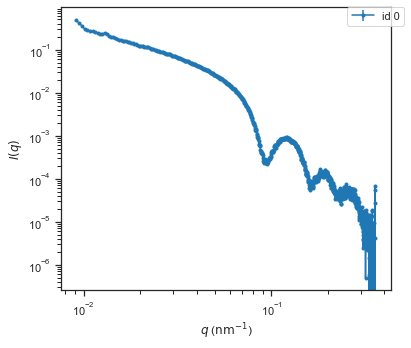

In [12]:
s = Soq(d)
s.plot_soq(0, Ae=0,)

## XPCS

In [13]:
from Xana import CorrFunc
import numpy as np

In [14]:
d.db['use'] = True

Merged g2 functions:  [0.00032] (exposure times)
                      [3] (number of correlation functions)
                      [4497] (total number of images)
Optimizing...(0)Fit successful: True


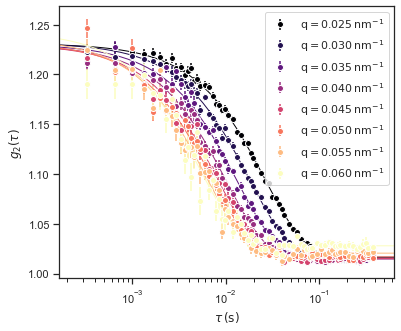

In [15]:
# initializing CorrFunc instance
g = CorrFunc(d)

# searching data base for xpcs measurements
ind = d.db[(d.db['analysis'] == 'xpcs')
          &(d.db['use'] == True)].index.values

#loading correlation functions
g.get_g2(ind, merge='merge')

# plotting
g.nq = np.arange(8)
g.plot_g2(doplot='data_legq_fit', color_mode=1, dofit=1, fix={}, init={'t0':(.02,0, None)}, 
          fitglobal=['g0','beta'])

In [12]:
d.discard_entry(3)


Results saved to:
	/Users/reiserm/Xana/docs/100nm_glycerol/Analysis_db.pkl


In [16]:
g.rescale(normby='fit', norm_contrast=True, contrast=1, baseline=1)

Optimizing...(0)Fit successful: True


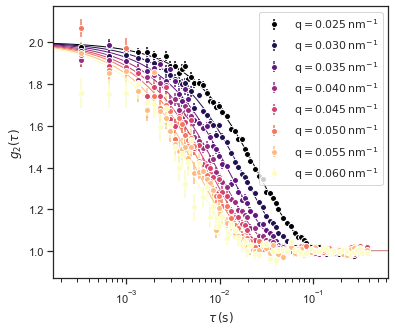

In [17]:
g.plot_g2(doplot='data_fit_legq', dofit=True, 
          fix={'a':1, 'g0':1, 'beta':1},)# init={'beta':(1,0,1), 't0':(.01,None,None), 'g0':(1,None,None)})

## Eventcorrelator

Merged g2 functions:  [0.00032] (exposure times)
                      [3] (number of correlation functions)
                      [4497] (total number of images)
Optimizing...(0)Fit successful: True


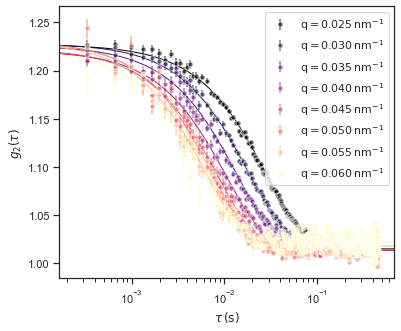

In [20]:
ge = CorrFunc(d)
ind = d.db[(d.db['analysis']=='xpcs_evt')
          &(d.db['use'])].index.values
ge.get_g2(ind, merge='merge')
ge.nq = np.arange(8)
ge.plot_g2(doplot='data_fit_legq', change_marker=1, markersize=5, alpha=.6, dofit=True, 
          fix={'g0':1,}, mode='semilogx', color_mode=0)

In [21]:
ge.rescale(normby='fit', norm_contrast=True, contrast=1, baseline=1)

Optimizing...(0)Fit successful: True


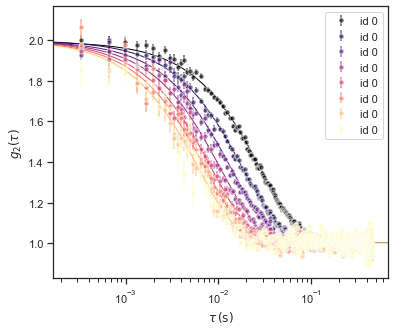

In [22]:
ge.plot_g2(doplot='data_fit_legd', change_marker=1, markersize=5, alpha=.6, dofit=True, 
          fix={'g0':1,}, mode='semilogx', color_mode=0)

### Comparing results from pyxpcs and eventcorrelator

In [23]:
gs = g + ge

In [24]:
g.pars[0]

,q,t0,dt0,g0,dg0,b0,db0,a,da,beta,dbeta,chisqr,redchi,bic,aic
0,0.025,0.052504,0.000375,1,0.0,1,0.0,1,0.0,1,0.0,428.479703,0.823999,-60.121569,-94.274339
1,0.030,0.035498,0.000283,1,0.0,1,0.0,1,0.0,1,0.0,428.479703,0.823999,-60.121569,-94.274339
2,0.035,0.026121,0.000242,1,0.0,1,0.0,1,0.0,1,0.0,428.479703,0.823999,-60.121569,-94.274339
3,0.040,0.020158,0.000227,1,0.0,1,0.0,1,0.0,1,0.0,428.479703,0.823999,-60.121569,-94.274339
4,0.045,0.016537,0.000230,1,0.0,1,0.0,1,0.0,1,0.0,428.479703,0.823999,-60.121569,-94.274339
5,0.050,0.014273,0.000251,1,0.0,1,0.0,1,0.0,1,0.0,428.479703,0.823999,-60.121569,-94.274339
6,0.055,0.012029,0.000278,1,0.0,1,0.0,1,0.0,1,0.0,428.479703,0.823999,-60.121569,-94.274339
7,0.060,0.010346,0.000325,1,0.0,1,0.0,1,0.0,1,0.0,428.479703,0.823999,-60.121569,-94.274339


TypeError: unsupported operand type(s) for -: 'float' and 'SingleBlockManager'

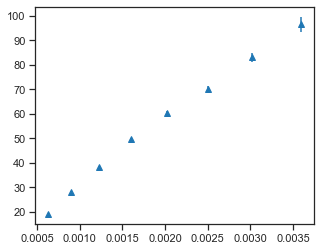

In [25]:
gs.plot_parameters(['G',], 
                  modes=([1],[1],),
                   alpha=(2,1,),
                   fit=('line',''),
                   fix=({'b':0}),
                   R=50e-9, viscosity=1, 
                   fit_report=1,);


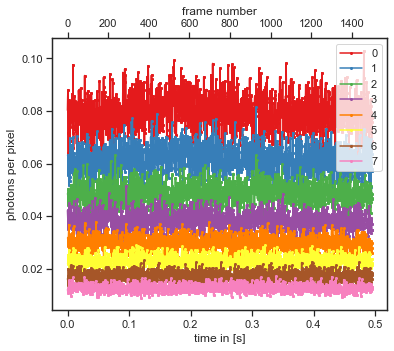

In [26]:
g.plot_trace(4)

In [27]:
g.plot_twotime(3, interpolation='nearest', clim=(1,2))

AttributeError: 'NoneType' object has no attribute 'set_title'

## XSVS

In [28]:
from Xana import VisbFunc

Loaded probabilities of 3 series.


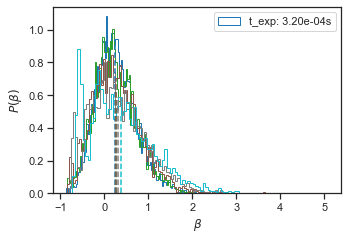

In [29]:
# initializing Visibility Func instance
v = VisbFunc(d)

# searching data base for xsvs results
ind = d.db[(d.db['analysis']=='xsvs')
          &(d.db['use'])].index.values

# loading probablities
v.get_prob(ind, merge=True)

# calculating contrast
v.calculate_contrast()

# plot histogram
v.quicklook(plot=['pbb'], nq=np.arange(5), color_mode=0, ratio=0, cmap='tab10', alpha=0.2)  

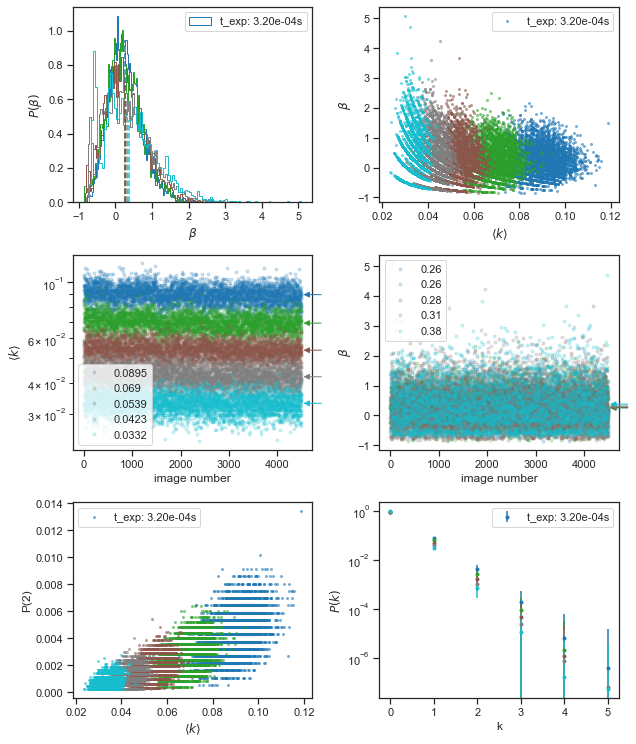

In [30]:
v.quicklook(plot=['pbb','bvkb', 'kbvi', 'bvi', 'pkvkb', 'pbk'],
                      idx=None, nq=np.arange(5), change_marker=0,
                       color_mode=1, maxlen=np.inf, ratio=0, probk=2,
                       cmap='tab10', lfs=8, total_counts=False, alpha=0.2)